<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module5/M5_1/Network_BonnerElectronics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Problems: Bonner Electronics
**OPIM 5641: Business Decision Modeling - University of Connecticut**

-----------------------

* Please refer to Powell Chapter 10 for more details and examples.
* Pyomo Cookbook (related example): https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/03.01-Transportation-Networks.ipynb

-------------------------------------------------------------------------

There are four main types of linear programming structures, three of which we covered in the previous module (allocation, covering, blending). The fourth type is the **network model**. Network models themselves fall into several categories, but what is common in our approach to all network models is that we use a diagram to help formulate and solve linear programming problems. 

The network model describes patterns of ﬂow in a connected system, where the ﬂow might involve material, people, or funds. The system elements may be locations, such as cities, warehouses, or assembly lines; or they may be points in time rather than points in space. When we construct diagrams to represent such systems, the elements are represented by **nodes**, or circles, in the diagram. The paths of ﬂow are represented by **arcs**, or arrows.

In [ ]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
    
from pyomo.environ import *

# Example
Bonner Electronics is planning next week’s shipments from its three manufacturing plants to its four distribution warehouses and is seeking a minimum-cost shipping schedule. Each plant has a potential capacity, expressed in cartons of product, and each warehouse has a week’s requirement that must be met. There are twelve possible shipment routes, and for each route, the unit shipping cost is known. The following table provides the given information for this example:

Plant | Atlanta | Boston | Chicago | Denver | Capacity
--- | --- | --- | --- | --- | ---
Minneapolis | 0.6 | 0.56 | 0.22 | 0.4 | 9,000
Pittsburgh | 0.36 | 0.3 | 0.28 | 0.58 | 12,000
Tucson | 0.65 | 0.68 | 0.55 | 0.42 | 13,000
--- | --- | --- | --- | --- | --- |
Requirement | 7,500 | 8,500 | 9,500 | 8,000

Here is an example of the network for this problem.
<center>

![Powell 10.2](https://drive.google.com/uc?export=view&id=1FF8w2kvTPS1M4iluNn3OdZXmCPFxHNq5)

Nodes are the circles, arcs are the arrows. Notice how each plant could support any other distribution warehouses. On your own, you can try to recreate this in Python using `NetworkX`. https://python-graph-gallery.com/network-chart/ If you do this, please share on the discussion board!



## Model Formulation

The transportation model has two kinds of constraints: less-than (or equal to) **capacity/supply constraints** and greater-than (or equal to) **demand constraints**, assuming that total demand does not exceed capacity (this is not always true - more on this in future examples!). 


### Supply Constraints
For the Minneapolis plant, we can express the capacity constraint as follows.

$MA + MB + MC + MD \leq 9,000$

In words, the total amount shipped out of Minneapolis must be less than or equal to the Minneapolis capacity. For Pittsburgh and Tucson, we have similar constraints: 

$PA + PB + PC + PD \leq 12,000$ 

$TA + TB + TC + TD \leq 13,000$

### Demand Constraints
For the Atlanta warehouse, the demand constraint reads: 
$MA + PA + TA \geq 7,500$ 

In words, the amount received at Atlanta must be greater than or equal to the Atlanta requirement. Similarly, for the other three warehouses, the demand constraint becomes:

$MB + PB + TB \geq 8,500$ 

$MC + PC + TC \geq 9,500$ 

$MD + PD + TD \geq 8,000$


# Objective Function and All Constraints

Putting both kinds of constraints together, and building an objective function from the same set of variables, we can create the following algebraic statement of the model:

$\min(z) = 0.60MA + 0.56MB + 0.22MC + 0.40MD + 0.36PA + 0.30PB + 0.28PC + 0.58PD + 0.65TA + 0.68TB + 0.55TC + 0.42TD$

subject to... supply constraints...
* $MA + MB + MC + MD \leq 9,000$
* $PA + PB + PC + PD \leq 12,000$ 
* $TA + TB + TC + TD \leq 13,000$

... and demand constraints...
* $MA + PA + TA \geq 7,500$ 
* $MB + PB + TB \geq 8,500$ 
* $MC + PC + TC \geq 9,500$ 
* $MD + PD + TD \geq 8,000$


# Building the Model in Pyomo (Using Dictionaries)
So long as you aren't doing a sensitivity analysis (shown later), this version of the code is appropriate for solving the problem. It is neat, compact and efficient - compared to the longer version where one types out every constraint manually (there is a real risk of typos here!)

In [ ]:
Demand = {
   'A':   7500,        # Atlanta
   'B':   8500,        # Boston
   'C':   9500,        # Chicago
   'D':   8000        # Denver
}

Supply = {
   'M':   9000,        # Minneapolis
   'P':   12000,         # Pittsburgh
   'T':   13000      # Tucson
}

# remember, it is DEMAND - SUPPLY pairs (might seem backwards)
T = {
    ('A','M'): 0.6,
    ('B','M'): 0.56,
    ('C','M'): 0.22,
    ('D','M'): 0.4,
    ('A','P'): 0.36,
    ('B','P'): 0.3,
    ('C','P'): 0.28,
    ('D','P'): 0.58,
    ('A','T'): 0.65,
    ('B','T'): 0.68,
    ('C','T'): 0.55,
    ('D','T'): 0.42
}

In [ ]:
# define the model
# Step 0: Create an instance of the model
model = ConcreteModel()

# Step 1: Define index sets - dictionary syntax {key : value}
CUS = list(Demand.keys()) # CUS = customers (demand)
SRC = list(Supply.keys()) # SRC = source (supply)

# Step 2: Define the decision 
model.x = Var(CUS, SRC, domain = NonNegativeReals)

# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([T[c,s]*model.x[c,s] for c in CUS for s in SRC]),
    sense = minimize)

In [ ]:
# Step 4: Add Constraints (note the ease in which this happens with for loops!)
model.src = ConstraintList()
for s in SRC:
    model.src.add(sum([model.x[c,s] for c in CUS]) <= Supply[s])
        
model.dmd = ConstraintList()
for c in CUS:
    model.dmd.add(sum([model.x[c,s] for s in SRC]) == Demand[c])

In [ ]:
# solve the model and show results
results = SolverFactory('cbc').solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12025.0
  Upper bound: 12025.0
  Number of objectives: 1
  Number of constraints: 8
  Number of variables: 13
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of creat

# Results

In [ ]:
# print the cost - checks out!
model.Cost()

12025.0

In [ ]:
# print the solution for how much goes in each node
for c in CUS:
    for s in SRC:
        print(c, s, model.x[c,s]())

A M 0.0
A P 3500.0
A T 4000.0
B M 0.0
B P 8500.0
B T 0.0
C M 9000.0
C P 0.0
C T 500.0
D M 0.0
D P 0.0
D T 8000.0


We can show the answer pictorially (you may be able to do this in Python using flow charts, left to students on their own). But here is what this looks like.

<center>

![Powell 10.5](https://drive.google.com/uc?export=view&id=1Xmf5_R96P8iiFoX0pQCNFKUUszhKFGok)


Take a second and realize that this problem is a little bit weird... you have more supply than demand, so the math works out. 

In [ ]:
# supply
supply = 9000 + 12000 + 13000
supply

34000

In [ ]:
# demand
demand = 7500 + 8500 + 9500 + 8000
demand

33500

In [ ]:
# difference
supply-demand # you have a surplus of 500

500

# A longer version of the code... Powell style...
But it will help us implement a more traditional sensitivity analysis on the binding constraints.

In [ ]:
# define the model
# Step 0: Create an instance of the model
model = ConcreteModel()

# write the variables 
# note how I am playing with integers (which technically makes this an integer program!)
# why integers? because I don't want to ship 0.38 widgets - we want to ship whole widgets.
model.MA = Var(domain=NonNegativeIntegers) # from Minneapolis factory to Atlanta Warehouse
model.MB = Var(domain=NonNegativeIntegers) # ...
model.MC = Var(domain=NonNegativeIntegers)
model.MD = Var(domain=NonNegativeIntegers)
model.PA = Var(domain=NonNegativeIntegers)
model.PB = Var(domain=NonNegativeIntegers)
model.PC = Var(domain=NonNegativeIntegers)
model.PD = Var(domain=NonNegativeIntegers)
model.TA = Var(domain=NonNegativeIntegers)
model.TB = Var(domain=NonNegativeIntegers)
model.TC = Var(domain=NonNegativeIntegers)
model.TD = Var(domain=NonNegativeIntegers)


In [ ]:
# Step 3: Define Objective
model.Cost = Objective(
    expr = 0.60*model.MA + 0.56*model.MB + 0.22*model.MC + 0.40*model.MD +
            0.36*model.PA + 0.30*model.PB + 0.28*model.PC + 0.58*model.PD +
            0.65*model.TA + 0.68*model.TB + 0.55*model.TC + 0.42*model.TD,
    sense = minimize)

A reminder...
subject to... supply constraints... $LHS \leq RHS$
* $MA + MB + MC + MD \leq 9,000$
* $PA + PB + PC + PD \leq 12,000$ 
* $TA + TB + TC + TD \leq 13,000$

... and demand constraints... $LHS \geq RHS$
* $MA + PA + TA \geq 7,500$ 
* $MB + PB + TB \geq 8,500$ 
* $MC + PC + TC \geq 9,500$ 
* $MD + PD + TD \geq 8,000$

In [ ]:
# Step 4:
# supply
model.SupplyM = Constraint(expr = model.MA + model.MB + model.MC + model.MD <= 9000)
model.SupplyP = Constraint(expr = model.PA + model.PB + model.PC + model.PD <= 12000)
model.SupplyT = Constraint(expr = model.TA + model.TB + model.TC + model.TD <= 13000)
# demand - note the USE OF EQUALITY CONSTRAINTS or GTE
model.DemandA = Constraint(expr = model.MA + model.PA + model.TA == 7500)
model.DemandB = Constraint(expr = model.MB + model.PB + model.TB == 8500)
model.DemandC = Constraint(expr = model.MC + model.PC + model.TC == 9500)
model.DemandD = Constraint(expr = model.MD + model.PD + model.TD == 8000)

In [ ]:
model.pprint()

12 Var Declarations
    MA : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeIntegers
    MB : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeIntegers
    MC : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeIntegers
    MD : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeIntegers
    PA : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeIntegers
    PB : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativ

Now solve it!

In [ ]:
# solve the model and show results
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 12025.0
  Upper bound: 12025.0
  Number of objectives: 1
  Number of constraints: 7
  Number of variables: 12
  Number of binary variables: 0
  Number of integer variables: 12
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound

Now double check your work (same as above).

In [ ]:
model.Cost()

12025.0

I confess that when I wrote this long-form, I had an error (infeasible solution) that I couldn't figure out for 30 minutes... it's because I wrote '9000' for the last demand constraint instead of 8000, and so I couldn't satisfy demand (and so the model breaks!). Later on in other scripts we will show how to have a 'virtual demand' or 'virtual supply' node to help with these problems.

In [ ]:
print('model.MA', model.MA())  # from Minneapolis factory to Atlanta Warehouse
print('model.MB', model.MB())
print('model.MC', model.MC())
print('model.MD', model.MD())
print('model.PA', model.PA())  # from Pennsylvania factory to Atlanta Warehouse
print('model.PB', model.PB())
print('model.PC', model.PC())
print('model.PD', model.PD())
print('model.TA', model.TA())  # from Tucson factory to Atlanta Warehouse
print('model.TB', model.TB())
print('model.TC', model.TC())
print('model.TD', model.TD())

model.MA 0.0
model.MB 0.0
model.MC 9000.0
model.MD 0.0
model.PA 3500.0
model.PB 8500.0
model.PC 0.0
model.PD 0.0
model.TA 4000.0
model.TB 0.0
model.TC 500.0
model.TD 8000.0


# Sensitivity Analysis with Boston
In the transportation model, we have supply and demand constraints, and the solution to the model provides shadow prices on each. The shadow price on a demand
constraint tells us how much it costs to ship the marginal unit to the corresponding location, and sometimes this ﬁgure is not obvious without some careful thought. 

Consider the demand at the Boston warehouse in the Bonner Electronics example. In the base case we just solved, Boston demand is 8,500 cartons. This quantity is all supplied from Pittsburgh, incurring a shipping cost of $0.30 per carton. Check the results above to verify.

Suppose we vary the demand parameter from 8,200 to 8,800 in steps of 100 and examine the optimal solution... we will need a for loop for this! Aren't you glad we wrote the long-form of the model?

In [ ]:
import numpy as np
np.arange(8200, 8900, 100)

array([8200, 8300, 8400, 8500, 8600, 8700, 8800])

In [ ]:
import numpy as np
import pandas as pd

myResults = pd.DataFrame() # empty place to store results


for a in np.arange(8200,8900, 100):
  print(a)
  # define the model
  # Step 0: Create an instance of the model
  model = ConcreteModel()

  # write the variables 
  model.MA = Var(domain=NonNegativeIntegers)
  model.MB = Var(domain=NonNegativeIntegers)
  model.MC = Var(domain=NonNegativeIntegers)
  model.MD = Var(domain=NonNegativeIntegers)
  model.PA = Var(domain=NonNegativeIntegers)
  model.PB = Var(domain=NonNegativeIntegers)
  model.PC = Var(domain=NonNegativeIntegers)
  model.PD = Var(domain=NonNegativeIntegers)
  model.TA = Var(domain=NonNegativeIntegers)
  model.TB = Var(domain=NonNegativeIntegers)
  model.TC = Var(domain=NonNegativeIntegers)
  model.TD = Var(domain=NonNegativeIntegers)

  # Step 3: Define Objective
  model.Cost = Objective(
      expr = 0.60*model.MA + 0.56*model.MB + 0.22*model.MC + 0.40*model.MD +
              0.36*model.PA + 0.30*model.PB + 0.28*model.PC + 0.58*model.PD +
              0.65*model.TA + 0.68*model.TB + 0.55*model.TC + 0.42*model.TD,
      sense = minimize)

  # Step 4:
  # supply
  model.SupplyM = Constraint(expr = model.MA + model.MB + model.MC + model.MD <= 9000)
  model.SupplyP = Constraint(expr = model.PA + model.PB + model.PC + model.PD <= 12000)
  model.SupplyT = Constraint(expr = model.TA + model.TB + model.TC + model.TD <= 13000)
  # demand - note the USE OF EQUALITY CONSTRAINTS
  model.DemandA = Constraint(expr = model.MA + model.PA + model.TA >= 7500)
  model.DemandB = Constraint(expr = model.MB + model.PB + model.TB >= a)
  model.DemandC = Constraint(expr = model.MC + model.PC + model.TC >= 9500)
  model.DemandD = Constraint(expr = model.MD + model.PD + model.TD >= 8000)

  # solve the model and show results
  SolverFactory('cbc').solve(model).write()

  # store results
  myX = pd.DataFrame([a, # the Boston Demand
                    model.Cost(),
                    model.MA(),
                    model.MB(),
                    model.MC(),
                    model.MD(),
                    model.PA(),
                    model.PB(),
                    model.PC(),
                    model.PD(),
                    model.TA(),
                    model.TB(),
                    model.TC(),
                    model.TD()])
  # take transpose (from many rows to one row)
  myX=myX.T # transpose

  # store the profit
  myResults = myResults.append(myX)

8200
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 11848.0
  Upper bound: 11848.0
  Number of objectives: 1
  Number of constraints: 7
  Number of variables: 12
  Number of binary variables: 0
  Number of integer variables: 12
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and 

In [ ]:
# Change the Column names
myResults = myResults.rename( {0:"Boston Demand", 1:"Cost",
                               2:"MA", 3:"MB" ,4:"MC", 5:"MD",
                               6:"PA", 7:"PB" ,8:"PC", 9:"PD",
                               10:"TA", 11:"TB" ,12:"TC", 13:"TD"}, axis='columns') 
myResults.reset_index(drop=True, inplace=True)

# check your work!
myResults

,Boston Demand,Cost,MA,MB,MC,MD,PA,PB,PC,PD,TA,TB,TC,TD
0,8200.0,11848.0,0.0,0.0,9000.0,0.0,3800.0,8200.0,0.0,0.0,3700.0,0.0,500.0,8000.0
1,8300.0,11907.0,0.0,0.0,9000.0,0.0,3700.0,8300.0,0.0,0.0,3800.0,0.0,500.0,8000.0
2,8400.0,11966.0,0.0,0.0,9000.0,0.0,3600.0,8400.0,0.0,0.0,3900.0,0.0,500.0,8000.0
3,8500.0,12025.0,0.0,0.0,9000.0,0.0,3500.0,8500.0,0.0,0.0,4000.0,0.0,500.0,8000.0
4,8600.0,12084.0,0.0,0.0,9000.0,0.0,3400.0,8600.0,0.0,0.0,4100.0,0.0,500.0,8000.0
5,8700.0,12143.0,0.0,0.0,9000.0,0.0,3300.0,8700.0,0.0,0.0,4200.0,0.0,500.0,8000.0
6,8800.0,12202.0,0.0,0.0,9000.0,0.0,3200.0,8800.0,0.0,0.0,4300.0,0.0,500.0,8000.0


Now you can break this out and show marginal cost by adding a new column.

In [ ]:
myResults['Shadow_BostonDemand'] = myResults['Cost'].diff()/myResults['Boston Demand'].diff()
myResults

,Boston Demand,Cost,MA,MB,MC,MD,PA,PB,PC,PD,TA,TB,TC,TD,Shadow_BostonDemand
0,8200.0,11848.0,0.0,0.0,9000.0,0.0,3800.0,8200.0,0.0,0.0,3700.0,0.0,500.0,8000.0,NaN
1,8300.0,11907.0,0.0,0.0,9000.0,0.0,3700.0,8300.0,0.0,0.0,3800.0,0.0,500.0,8000.0,0.59
2,8400.0,11966.0,0.0,0.0,9000.0,0.0,3600.0,8400.0,0.0,0.0,3900.0,0.0,500.0,8000.0,0.59
3,8500.0,12025.0,0.0,0.0,9000.0,0.0,3500.0,8500.0,0.0,0.0,4000.0,0.0,500.0,8000.0,0.59
4,8600.0,12084.0,0.0,0.0,9000.0,0.0,3400.0,8600.0,0.0,0.0,4100.0,0.0,500.0,8000.0,0.59
5,8700.0,12143.0,0.0,0.0,9000.0,0.0,3300.0,8700.0,0.0,0.0,4200.0,0.0,500.0,8000.0,0.59
6,8800.0,12202.0,0.0,0.0,9000.0,0.0,3200.0,8800.0,0.0,0.0,4300.0,0.0,500.0,8000.0,0.59


**WHOA!** How do we reconcile the direct cost of \$0.30 on the Pittsburgh-Boston route with the marginal cost of $0.59? Let's see if we can dig into the table we just generated and see what's going on.

First, note that M is exclusively feeding C. It has used up all of it's resources.

Now look at PA and PB and TA. As we increase the Boston demand, A is being fed by T instead of P. So yes, we can take care of the extra demand in Boston, but it is going to cost us!

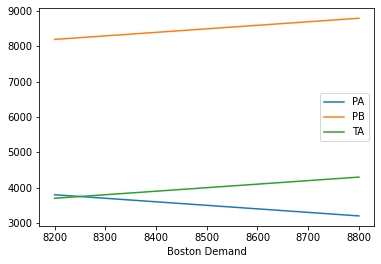

In [ ]:
tmp = myResults[['Boston Demand', 'PA', 'PB', 'TA']]
tmp.plot(x='Boston Demand')